In [ ]:
!unzip -q /content/drive/MyDrive/바이오_AI.zip

In [ ]:
!pip install Bio
!pip install catboost
!pip install pycaret

In [ ]:
import sys
import random
import pandas as pd
import numpy as np
import os
import torch
import pickle
from tqdm import tqdm
import Bio
from Bio.SeqUtils.ProtParam import ProteinAnalysis

from tqdm import tqdm
import sklearn
from sklearn.metrics import f1_score
import warnings
import catboost

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sbn

warnings.filterwarnings(action='ignore')
print('파이썬 버전 : '+sys.version)
print('catboost 버전 : '+catboost.__version__)
print('torch 버전 : '+torch.__version__)
print('numpy 버전 : '+np.__version__)
print('pandas 버전 : '+pd.__version__)
print('sklearn 버전 : '+sklearn.__version__)
!nvidia-smi # gpu 환경 A100

파이썬 버전 : 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
catboost 버전 : 1.2
torch 버전 : 2.0.1+cu118
numpy 버전 : 1.22.4
pandas 버전 : 1.5.3
sklearn 버전 : 1.2.2
Tue Jul  4 11:45:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+------------

In [ ]:
# 시드값 고정
CFG = {
    'SEED':51
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

In [ ]:
# Cuda 설정
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
AMINO_LIST = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
PH_RANGE = range(1, 10, 2)

In [ ]:
warnings.filterwarnings(action='ignore')
def get_amino_features(seq):
    f = ProteinAnalysis(seq)
    new_col = [f.aromaticity(), f.gravy(), f.instability_index(), f.isoelectric_point(), f.length, f.molecular_weight(), f.monoisotopic]

    f_cysteines, f_cystines = f.molar_extinction_coefficient()
    new_col += [f_cysteines, f_cysteines]

    f_helix, f_turn, f_sheet = f.secondary_structure_fraction()
    new_col += [f_helix, f_turn, f_sheet]

    #f.features.flexibility()
    #f.protein_scale()

    new_col += [f.charge_at_pH(ph) for ph in PH_RANGE]

    f_amino_cnt = f.count_amino_acids()
    new_col += [f_amino_cnt[alpha] for alpha in AMINO_LIST]

    f_amino_per = f.get_amino_acids_percent()
    new_col += [f_amino_per[alpha] for alpha in AMINO_LIST]

    return new_col

def preprocess_df(df):
    # amino features
    new_cols = []
    for k in ['frag_1', 'frag_2']:
        tqdm.pandas()
        new_arr = df.progress_apply(lambda row: get_amino_features(row[k]), axis=1)

        new_key = [k+'_aromaticity', k+'_gravy', k+'_instability_index', k+'_isoelectric_point', k+'_length', k+'_molecular_weight', k+'_monoisotopic']
        new_key += [k+'_molar_extinction_coefficient_cysteines', k+'_molar_extinction_coefficient_cystines']
        new_key += [k+'_secondary_structure_fraction_helix', k+'_secondary_structure_fraction_turn', k+'_secondary_structure_fraction_sheet']
        new_key += [k+'_charge_at_pH_'+str(ph) for ph in PH_RANGE]
        new_key += [k+'_count_amino_acids_'+alpha for alpha in AMINO_LIST]
        new_key += [k+'_get_amino_acids_percent_'+alpha for alpha in AMINO_LIST]

        df_new = pd.DataFrame(new_arr.values.tolist(), columns=new_key)
        new_cols.append(df_new)
        print('Done', k, 'sequence.')

    # Table features
    df = df.drop(['ID', 'frag_1', 'frag_2'], axis=1)
    df = pd.concat([df]+new_cols, axis=1)
    # One-hot encoding

    return df

In [ ]:
df = pd.read_csv('./train.csv')
test_df= pd.read_csv('./test.csv')

In [ ]:
pd.options.display.float_format = '{:.5f}'.format


In [ ]:
def EDA_sequence_length(df):
  seq_length=[]
  for i in range (len(df.frag_1)):
    seq_length.append([len(df.frag_1[i])])
  seq_length=pd.DataFrame(seq_length)
  return seq_length

In [ ]:
seq_length=EDA_sequence_length(df)
seq_length.describe()

,0
count,1699067.00000
mean,6.50060
std,2.14929
min,3.00000
25%,5.00000
50%,6.00000
75%,8.00000
max,57.00000


In [ ]:
df.describe()


,h_bond_distance
count,1699067.00000
mean,19.29865
std,3.97253
min,4.00000
25%,17.00000
50%,19.00000
75%,21.00000
max,37.00000


In [ ]:
df = preprocess_df(df)


100%|██████████| 1699067/1699067 [03:22<00:00, 8376.91it/s]


Done frag_1 sequence.


100%|██████████| 1699067/1699067 [03:24<00:00, 8317.34it/s]


Done frag_2 sequence.


In [ ]:
df.to_csv('./train_preprocessed_data.csv', index=False)


In [ ]:
df = pd.read_csv('./train_preprocessed_data.csv')
test_df=pd.read_csv('./test.csv')


In [ ]:
train_df=df.drop(['h_bond_distance'],axis=1)
train_label=df.h_bond_distance

In [ ]:
train_df.describe()


,frag_1_aromaticity,frag_1_gravy,frag_1_instability_index,frag_1_isoelectric_point,frag_1_length,frag_1_molecular_weight,frag_1_molar_extinction_coefficient_cysteines,frag_1_molar_extinction_coefficient_cystines,frag_1_secondary_structure_fraction_helix,frag_1_secondary_structure_fraction_turn,...,frag_2_get_amino_acids_percent_M,frag_2_get_amino_acids_percent_N,frag_2_get_amino_acids_percent_P,frag_2_get_amino_acids_percent_Q,frag_2_get_amino_acids_percent_R,frag_2_get_amino_acids_percent_S,frag_2_get_amino_acids_percent_T,frag_2_get_amino_acids_percent_V,frag_2_get_amino_acids_percent_W,frag_2_get_amino_acids_percent_Y
count,1699067.00000,1699067.00000,1699067.00000,1699067.00000,1699067.00000,1699067.00000,1699067.00000,1699067.00000,1699067.00000,1699067.00000,...,1699067.00000,1699067.00000,1699067.00000,1699067.00000,1699067.00000,1699067.00000,1699067.00000,1699067.00000,1699067.00000,1699067.00000
mean,0.12190,0.77500,22.09483,6.46814,6.50060,750.54022,1163.92973,1163.92973,0.46972,0.15710,...,0.02302,0.02576,0.01901,0.02734,0.04162,0.05283,0.06823,0.13726,0.01579,0.05342
std,0.13506,1.24454,39.76597,2.03772,2.14929,258.25957,2179.90603,2179.90603,0.18508,0.15241,...,0.06211,0.06471,0.05741,0.06620,0.08222,0.09655,0.10416,0.14366,0.05114,0.09237
min,0.00000,-4.50000,-105.22500,4.05003,3.00000,189.16920,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,-0.06667,-5.48182,5.23978,5.00000,571.66670,0.00000,0.00000,0.33333,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,0.11111,0.77000,8.33333,5.52500,6.00000,702.90590,0.00000,0.00000,0.50000,0.14286,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.14286,0.00000,0.00000
75%,0.20000,1.61111,40.75455,8.46903,8.00000,883.99190,1490.00000,1490.00000,0.60000,0.25000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.11111,0.14286,0.20000,0.00000,0.11111
max,1.00000,4.50000,437.10000,11.99997,57.00000,6631.13730,49500.00000,49500.00000,1.00000,1.00000,...,0.66667,0.75000,1.00000,0.75000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [ ]:
abs(df.corrwith(other = df.h_bond_distance, method = 'pearson')).sort_values(ascending=False)[:30]


h_bond_distance                                 1.00000
frag_2_length                                   0.76555
frag_1_length                                   0.76555
frag_2_molecular_weight                         0.73147
frag_1_molecular_weight                         0.72890
frag_1_charge_at_pH_1                           0.28637
frag_1_charge_at_pH_3                           0.27829
frag_2_charge_at_pH_1                           0.25836
frag_2_charge_at_pH_3                           0.24941
frag_2_count_amino_acids_S                      0.22744
frag_1_count_amino_acids_T                      0.21053
frag_2_count_amino_acids_T                      0.20149
frag_1_count_amino_acids_E                      0.19444
frag_1_gravy                                    0.19407
frag_1_count_amino_acids_S                      0.19152
frag_2_count_amino_acids_E                      0.18997
frag_2_count_amino_acids_R                      0.18719
frag_2_count_amino_acids_G                      

In [ ]:
df = pd.read_csv('./train_preprocessed_data.csv')


In [ ]:
from pycaret.regression import *
df_reg_ = setup(data = df, target = 'h_bond_distance',use_gpu=True)

,Description,Value
0,Session id,4139
1,Target,h_bond_distance
2,Target type,Regression
3,Original data shape,"(1699067, 115)"
4,Transformed data shape,"(1699067, 115)"
5,Transformed train set shape,"(1189346, 115)"
6,Transformed test set shape,"(509721, 115)"
7,Numeric features,112
8,Preprocess,True
9,Imputation type,simple


In [ ]:
compare_models(sort = 'RMSE')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:33:40
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,1.6754,6.2504,2.5000,0.6040,0.1176,0.0873,18.4890
ridge,Ridge Regression,1.6799,6.2683,2.5036,0.6028,0.1177,0.0875,11.8640
br,Bayesian Ridge,1.6799,6.2683,2.5036,0.6028,0.1177,0.0875,17.5110
omp,Orthogonal Matching Pursuit,1.6926,6.4684,2.5433,0.5901,0.1187,0.0883,11.8070
en,Elastic Net,1.8133,6.9327,2.6330,0.5607,0.1235,0.0946,19.7020
lasso,Lasso Regression,1.8139,6.9336,2.6331,0.5607,0.1235,0.0947,19.4780
llar,Lasso Least Angle Regression,1.9289,7.4630,2.7282,0.5272,0.1283,0.1009,12.0820
huber,Huber Regressor,1.9670,8.9217,2.9856,0.4348,0.1420,0.0996,111.1190
par,Passive Aggressive Regressor,4.3751,40.0859,5.8813,-1.5453,0.3277,0.2295,37.2320
lar,Least Angle Regression,102637716388066188319646201186310618895359693291520.0000,183409429943662278263242914448754534097820983039995896469926346112087657708647087556700221755413757952.0000,135428737697603281684774674783295951112681704914944.0000,-11629722571199275518536690214488921484016564487607213582983431623015074978225695752864539187894812672.0000,37.5580,5400943380531761482770084626799452926553716948992.0000,11.4140


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [ ]:
df = pd.read_csv('./train_preprocessed_data.csv')
train_df=df.drop(['h_bond_distance'],axis=1)
train_label=df.h_bond_distance

In [ ]:
from sklearn.metrics import f1_score, classification_report
from catboost import CatBoostRegressor
import os
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.model_selection import train_test_split

train_df, val_df, train_label, val_label = train_test_split(train_df, train_label, test_size=0.3, random_state=CFG['SEED'])
cat_reg=CatBoostRegressor(
        n_estimators = 4000000,
        learning_rate = 1e-2,
        loss_function='RMSE',
        task_type="GPU",
        devices='0:2'
)

cat_reg.fit(train_df,train_label,
    eval_set = [(val_df,val_label)],
    early_stopping_rounds = 10000,
    verbose = 10000
    )

y_hat = cat_reg.predict(val_df)

#     print(f1_score(valid_y,y_hat, pos_label = 0))
#     print(f1_score(valid_y,y_hat, pos_label = 1))
#     print(f1_score(valid_y,y_hat, average = 'macro'))

0:	learn: 3.9498198	test: 3.9461472	best: 3.9461472 (0)	total: 8.77ms	remaining: 9h 44m 49s
10000:	learn: 2.0279684	test: 2.0428192	best: 2.0428192 (10000)	total: 1m 15s	remaining: 8h 20m 57s
20000:	learn: 1.9011764	test: 1.9319683	best: 1.9319683 (20000)	total: 2m 30s	remaining: 8h 20m 19s
30000:	learn: 1.8158832	test: 1.8606217	best: 1.8606217 (30000)	total: 3m 46s	remaining: 8h 18m 41s
40000:	learn: 1.7517600	test: 1.8084338	best: 1.8084338 (40000)	total: 5m 1s	remaining: 8h 17m 10s
50000:	learn: 1.6999244	test: 1.7672008	best: 1.7672008 (50000)	total: 6m 16s	remaining: 8h 16m 4s
60000:	learn: 1.6564629	test: 1.7335561	best: 1.7335561 (60000)	total: 7m 32s	remaining: 8h 14m 53s
70000:	learn: 1.6187779	test: 1.7049806	best: 1.7049806 (70000)	total: 8m 46s	remaining: 8h 13m
80000:	learn: 1.5857500	test: 1.6803608	best: 1.6803608 (80000)	total: 10m 1s	remaining: 8h 11m 13s
90000:	learn: 1.5562183	test: 1.6587101	best: 1.6587101 (90000)	total: 11m 15s	remaining: 8h 9m 10s
100000:	learn:

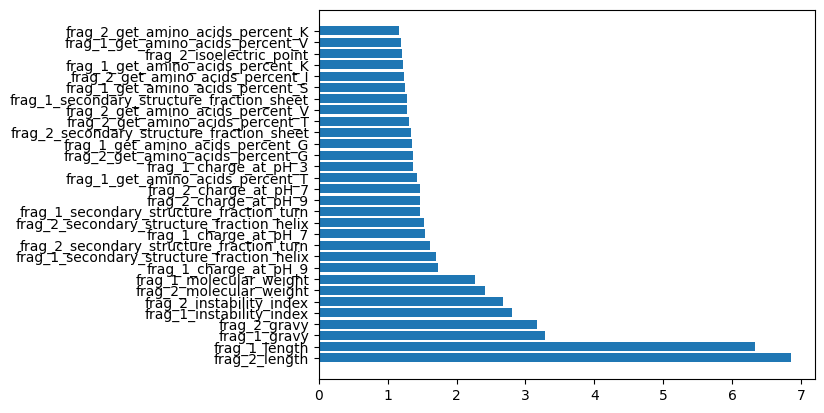

In [ ]:
cat_importance_feature = np.argsort(cat_reg.feature_importances_)[:-31:-1]
plt.barh(train_df.columns[cat_importance_feature], cat_reg.feature_importances_[cat_importance_feature])
plt.show()

In [ ]:
test_df = pd.read_csv('./test.csv')


In [ ]:
test_df = preprocess_df(test_df)


100%|██████████| 163537/163537 [00:18<00:00, 8633.51it/s]


Done frag_1 sequence.


100%|██████████| 163537/163537 [00:19<00:00, 8456.56it/s]


Done frag_2 sequence.


In [ ]:
preds=cat_reg.predict(test_df)


In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['h_bond_distance'] = preds
submit.head()

,ID,h_bond_distance
0,TEST_000000,18.28804
1,TEST_000001,15.75478
2,TEST_000002,17.00431
3,TEST_000003,19.03171
4,TEST_000004,14.73668


In [ ]:
submit.to_csv('./submit_feature_extraction_cat_lr0.001.csv', index=False)


In [ ]:
from google.colab import files
files.download("./submit_feature_extraction_cat_lr0.001.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>